In [1]:
from utils import *
import os, shutil

In [2]:
class HAEA:
    
    
    def __init__(self, nombre,persons,
                 individuals,mode_initial_pop,
                 n_generations,
                 p_mutation=None,
                 generacional=False,
                 fitness_func=fitness_basic,
                 n_offsprings=1,
                 operators=[(mutation_usual,1),(crossover_usual,2)]#,(swap_mutation,1)]
                ):
        
        self.nombre=nombre
        self.persons = persons
        self.gens = int(persons*(persons-1)/2)
        self.individuals=individuals
        self.current_population=None
        self.mode_initial_pop=mode_initial_pop
        self.fitness_func=fitness_func
        self.fitness={}
        self.n_generations=n_generations
        self.current_generation=1
        self.generations={1:{}}
        if not p_mutation:
            p_mutation=1.0/self.gens
        self.p_mutation=p_mutation
        self.generacional=generacional
        self.n_offsprings=n_offsprings
        self.operators=operators
        p_operators=np.random.rand(len(operators))
        self.p_operators=p_operators/p_operators.sum()
        self.historial_p_operators={1:self.p_operators}
               
        
        import warnings
        warnings.filterwarnings("ignore", category=FutureWarning)

        
    def info(self):
        
        I=pd.DataFrame([self.nombre,self.persons,self.gens,
                        self.individuals,self.p_mutation,
                        self.generacional,self.operators,self.p_operators
                       ],
                       index=["Name","Persons","Gens",
                              "individuals","p_mutation",
                              "generacional","operators",'p_operators'                                
                               ],
                       columns=["Values"]
        )
        return I
        
        
    def generate_pop_ini(self):
        self.mode_initial_pop(self)
        
    def validate_grade_individual(self,individual):
        
        n=self.persons
        X=convert_individual_to_graph(n,individual)
        return sum(dict(nx.degree(X)).values())/n
        
    def show_dist_deggre_pop(self,size=(12,5),save=None):
        D=list(map(self.validate_grade_individual,self.current_population))
        fig = plt.figure()
        fig.set_size_inches(size[0], size[1])
        ax1 = fig.add_subplot(121)
        ax1.set_title("Distribution")
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points")
        ax1.set_xlabel("Average Degree")
        ax1.set_ylabel("Frequency")
        ax2.set_xlabel("Average Degree")
        sns.distplot(D,kde=False,ax=ax1)
        sns.swarmplot(x=D,ax=ax2)
        
        if save:
            plt.savefig(save,dpi=300)
            
        plt.show()
            
    def evaluate_fitness_ind(self,individual):

        t_f=t_form(individual)
        
        if t_f not in self.fitness:
            #print(self.fitness_func(individual))
            return self.fitness_func(individual)            
        else:
            #print(self.fitness[t_f])
            return self.fitness[t_f]
            
    def evaluate_pop(self,P,offspring=None):
        #import multiprocessing
        #from joblib import Parallel, delayed
        #num_cores = multiprocessing.cpu_count()
        
        #values = Parallel(n_jobs=num_cores)(delayed(self.evaluate_fitness_ind)(i) for i in P)
        
        values = list(map(self.evaluate_fitness_ind,P))
                
        for i,v in zip(P,values):
            self.fitness[t_form(i)]=v
        
        if not offspring:
            self.generations[self.current_generation]={"Average Fitness":np.mean(values),
                                                       "Best Individual":P[np.argmax(values)],
                                                       "Fitness Best":np.max(values),
                                                       "Fitness Worst":np.min(values),
            }
            
            return np.array(values),self.generations[self.current_generation] 
        else:
            return values
        
        
    def get_offspring(self,individual):
        n_offsprings=self.n_offsprings
        index_operator=np.random.choice(np.arange(len(self.operators)),p=self.p_operators)
        operator,d=self.operators[index_operator]

        if d == 1:   
            offspring=np.zeros((n_offsprings,self.gens))
            for i in range(n_offsprings):
                offspring[i]=self.operators[index_operator][0](individual,self.persons)
        else:
            offspring=np.zeros((n_offsprings*2,self.gens))
            for i in range(n_offsprings):
                individual2=self.current_population[np.random.choice(self.individuals)]
                offspring[i:i+2]=np.array(self.operators[index_operator][0](individual,individual2,self.persons,0.9))



        offspring=np.array(offspring)

        return offspring,index_operator
    
    def select_best(self,individual,hijos,index_operator):
        best=hijos[np.argmax(self.evaluate_pop(hijos,offspring=True))]

        if self.evaluate_fitness_ind(individual) > self.evaluate_fitness_ind(best):
            new = individual
        else:
            new = best
        delta = np.random.rand()
        if self.evaluate_fitness_ind(individual) >= self.evaluate_fitness_ind(best):
            self.p_operators[index_operator] = (self.p_operators[index_operator])*(1-delta)
        else:
            self.p_operators[index_operator] = (self.p_operators[index_operator])*(1+delta)
            
        p_operators=self.p_operators/self.p_operators.sum()
        
        self.p_operators=p_operators

        self.historial_p_operators[len(self.historial_p_operators)+1]=np.around(self.p_operators,2)

        return new
    
    def evolution_ind(self,individual):
        hijos,d=self.get_offspring(individual)
        return self.select_best(individual,hijos,d)
    
    def evolution(self):
        self.evaluate_pop(self.current_population)
        new_P=np.zeros((self.individuals,self.gens))
        for idx,i in enumerate(self.current_population):
            new_P[idx]=self.evolution_ind(i)
        self.current_population=new_P
        self.current_generation+=1
        self.fitness={}
        return 0
        
    
    def plot_results(self,size=(12,5),save=None):
        fig = plt.figure()
        fig.set_size_inches(size[0], size[1])
        ax1 = fig.add_subplot(111)
        ax1.set_title("Results")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        
        sns.lineplot(np.arange(self.current_generation-1),
                     [ i['Average Fitness'] for i in self.generations.values()],
                     ax=ax1,ci='sd',
                     label='Average Fitness')
        sns.lineplot(np.arange(self.current_generation-1),
                     [ i['Fitness Best'] for i in self.generations.values()],
                     ax=ax1,
                     label='Fitness Best')
        sns.lineplot(np.arange(self.current_generation-1),
                     [ i["Fitness Worst"] for i in self.generations.values()],
                     ax=ax1,
                     label="Fitness Worst")      
        if save:
            plt.savefig(save,dpi=300)
            
        plt.show()
            
    def run(self,size=(12,5),save_dist=None,save_results=None):
        self.generate_pop_ini()
        self.show_dist_deggre_pop(size=size,save=save_dist)
        for i in range(self.n_generations):
            self.evolution()
            self.show_dist_deggre_pop()
        self.plot_results(size=size,save=save_results)
        
    def run_alone(self,size=(12,5),path_dir="",console=True,plots=10):
        
        if console == True:
            matplotlib.use('Agg')
        
        if os.path.exists(path_dir):
            shutil.rmtree(path_dir)
        os.mkdir(path_dir)
        self.info().to_csv(os.path.join(path_dir,"Info.csv"))
        self.generate_pop_ini()
        #print(self.fitness_func)
        #print(False in [validate_individual(self.persons,i) for i in self.current_population])
        self.show_dist_deggre_pop(size=size,save=os.path.join(path_dir,"Dist_ini.pdf"))
        
        folder_generations=os.path.join(path_dir,"generations")
        os.mkdir(folder_generations)
        for i in range(self.n_generations):
            self.evolution()
            #print(False in [validate_individual(self.persons,i) for i in self.current_population])
            if i in np.around(np.linspace(plots,self.n_generations,plots)) :
                self.show_dist_deggre_pop(size=size,save=os.path.join(folder_generations,"generation_"+str(i)+".pdf"))
        
        pd.DataFrame(self.generations).T.to_csv(os.path.join(path_dir,"results_generations.csv"))
        self.plot_results(size=size,save=os.path.join(path_dir,"Results.pdf"))
        
        np.save(os.path.join(path_dir,"best.npy"),self.generations[self.n_generations]['Best Individual'])
        
        return 0

In [3]:
H=HAEA(nombre="t1",
       persons=100,
       individuals=50,
       mode_initial_pop=pop_ini_bin_fixed,
       n_generations=30,
       p_mutation=None,
       generacional=False,
       fitness_func=fitness_basic,
       operators=[(mutation_usual,1),(crossover_usual,2),(swap_mutation,1)],
       n_offsprings=1
      )

In [494]:
H.generate_pop_ini()

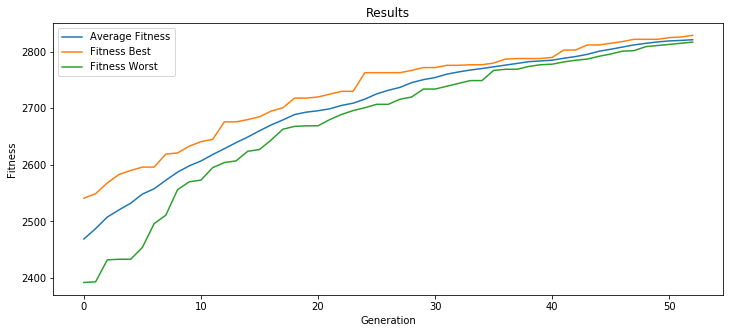

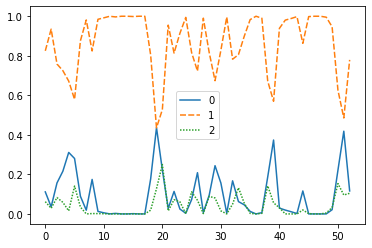

In [552]:
H.evolution()
H.plot_results()

means=[]
for i in range(H.current_generation-1):
    means.append(pd.DataFrame(H.historial_p_operators).T.loc[range(i*H.individuals,(i+1)*H.individuals)].mean(axis=0).values)
means=pd.DataFrame(means)
sns.lineplot(data=means)

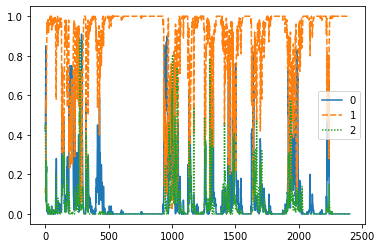

In [547]:
sns.lineplot(data=pd.DataFrame(H.historial_p_operators).T)